Import Libraries

In [1]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

Load and Preprocess the Data

In [2]:
# Load the dataset
file_path = 'GOOGL_2006-01-01_to_2018-01-01.csv'
df1 = pd.read_csv(file_path, parse_dates=['Date'])  # Parse 'Date' as datetime
df1.set_index('Date', inplace=True)  # Set 'Date' as the index
df1 = df1.drop('Name', axis=1)  # Drop unnecessary 'Name' column

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df1.values)



Prepare Sequences for RNN

In [3]:
# Define sequence length
sequence_length = 100

# Prepare input (X) and output (Y) sequences
X, Y = [], []
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
    Y.append(data_normalized[i + sequence_length])    # Output: num_features

X = np.array(X)  # Shape: (samples, sequence_length, num_features)
Y = np.array(Y)  # Shape: (samples, num_features)

Split Data into Training and Testing Sets

In [4]:
# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]



Build and Compile the RNN Model

In [7]:
# Build the LSTM model for multivariate input/output
model = Sequential([
    SimpleRNN(units=80, input_shape=(sequence_length, X.shape[2])),  # Sequence length and features
    Dense(units=Y.shape[1])  # Number of output features
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')




Train the LSTM Model

In [8]:
# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=20, verbose=1)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0157
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.7621e-04
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.0228e-04
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9848e-04
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0346e-04
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.4106e-04
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.4923e-04
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.8296e-04
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8157e-04
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9830e-04
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.2313e-04
Epoch 12/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.8751e-04
Epoch 13/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.8413e-04
Epoch 14/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.

Predict on the Test Set

In [9]:
# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale predictions and actual values for evaluation
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = root_mean_squared_error(Y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 192813.10384375876


 Visualize Actual vs Predicted

Root Mean Squared Error: 15.65546049413792
Root Mean Squared Error: 18.03869037727544
Root Mean Squared Error: 13.198160473189379
Root Mean Squared Error: 24.211926472882382
Root Mean Squared Error: 1039449.0195754066


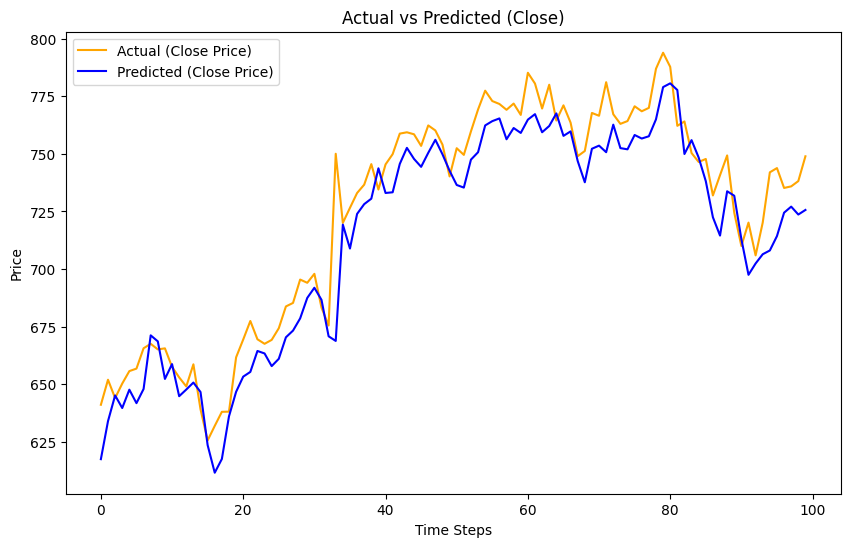

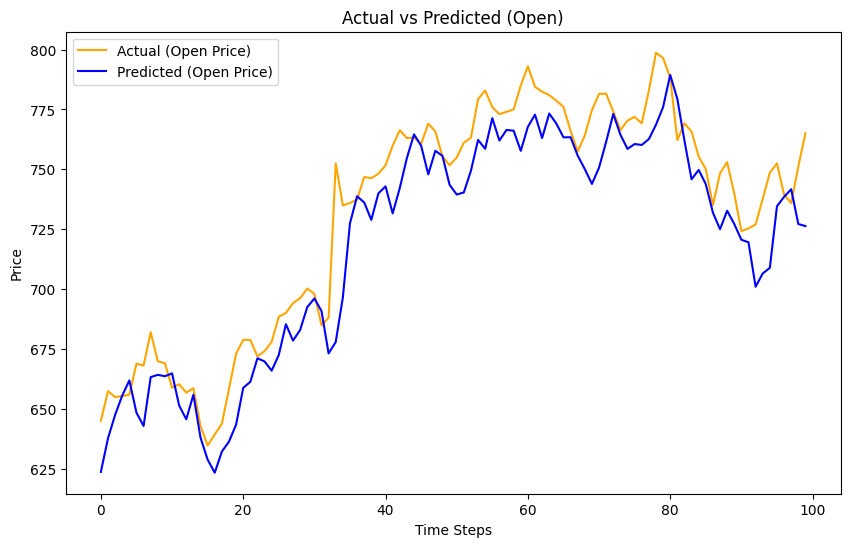

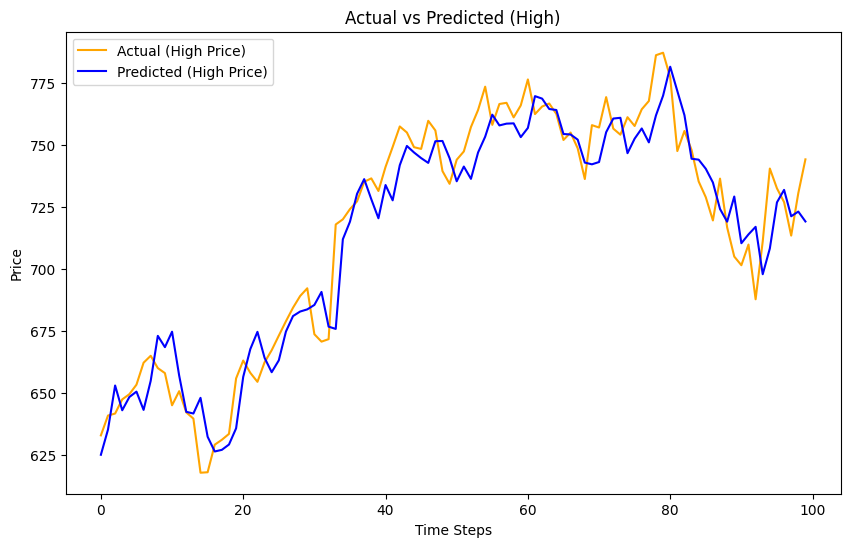

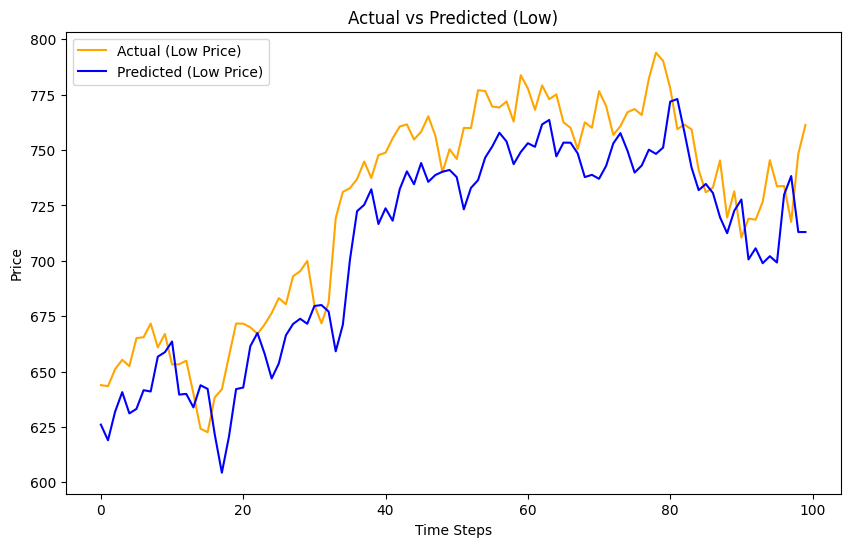

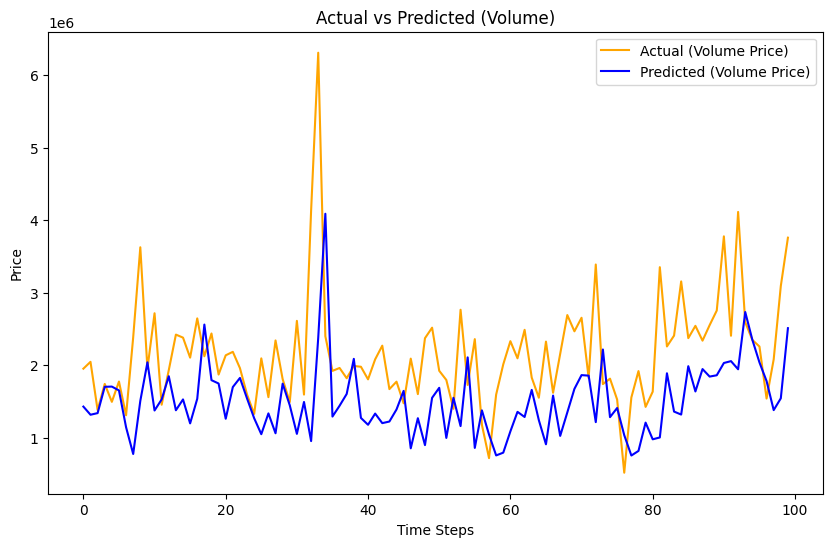

In [10]:
# Plot Actual vs Predicted (Close Price)
variables=["Close", "Open", "High", "Low", "Volume"]
for i in range(0,5):
    variable=variables[i]
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test_rescaled[:100, i], label='Actual ('+variable+' Price)', color='orange')
    plt.plot(predictions_rescaled[:100, i], label='Predicted ('+variable+' Price)', color='blue')
    plt.legend()
    plt.title("Actual vs Predicted ("+variable+")")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.savefig("Actual_vs_Predicted("+variable+"Price)_training.png")
    mse = root_mean_squared_error(Y_test_rescaled[:100,i], predictions_rescaled[:100,i])
    print(f"Root Mean Squared Error: {mse}")


Forecast Future Values

In [21]:
# Forecasting future values
forecast_input = X[0]  # Initialize with the first sequence
forecast_steps = 100  # Number of future steps to forecast
forecasts = []

for _ in range(forecast_steps):
    forecast_input_reshaped = forecast_input.reshape(1, sequence_length, X.shape[2])
    forecast = model.predict(forecast_input_reshaped)[0]
    forecasts.append(forecast)
    forecast_input = np.vstack([forecast_input[1:], forecast])  # Update the input sequence

# Convert forecasts to the original scale
forecasts_rescaled = scaler.inverse_transform(np.array(forecasts))  # Rescale forecasts to original values
print("Forecasts (original scale):")
print(forecasts_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

Root Mean Squared Error: 618.0588869438258
Root Mean Squared Error: 642.2418545125716
Root Mean Squared Error: 614.4984204050679
Root Mean Squared Error: 604.6025670859419
Root Mean Squared Error: 5980638.77457251


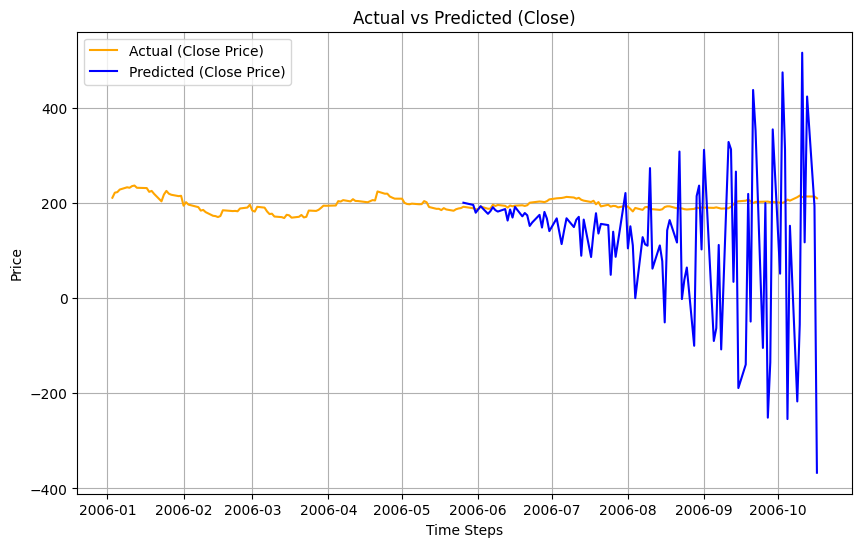

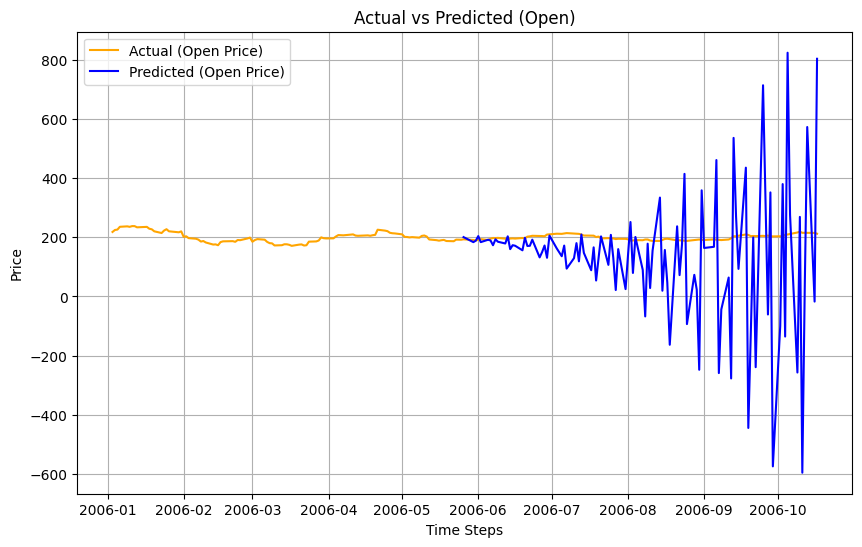

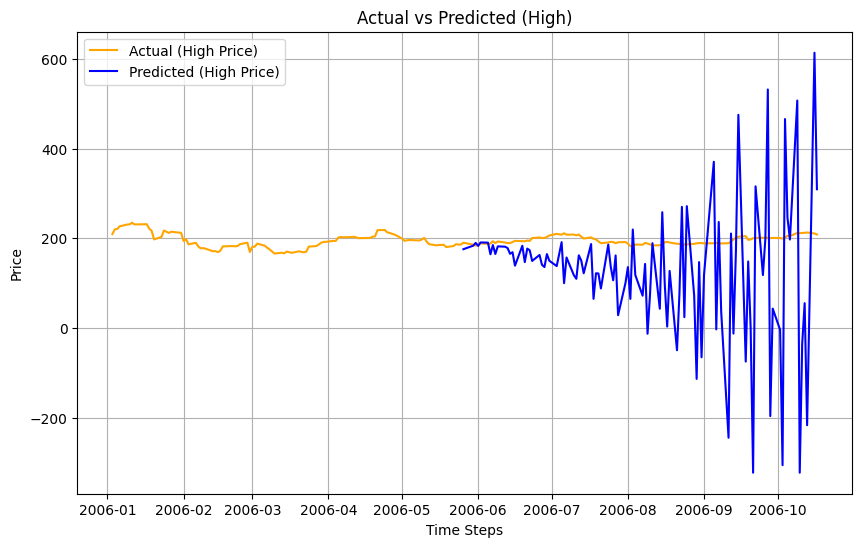

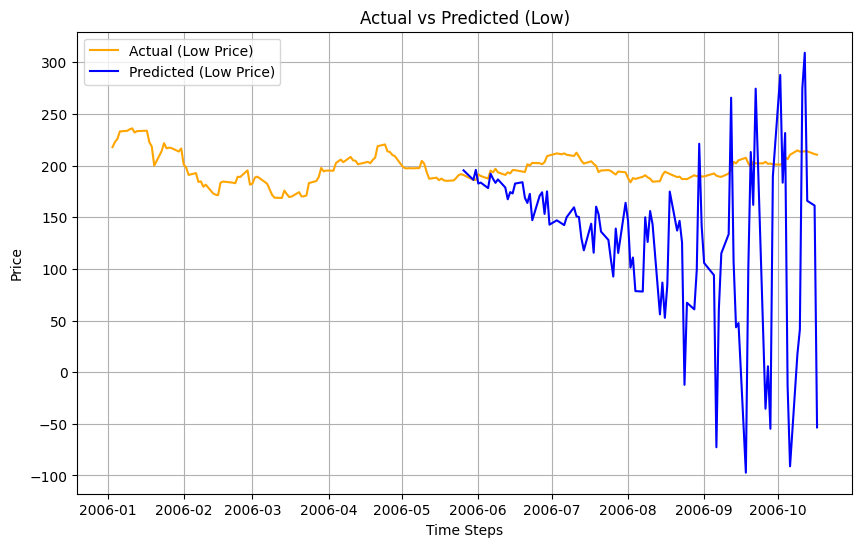

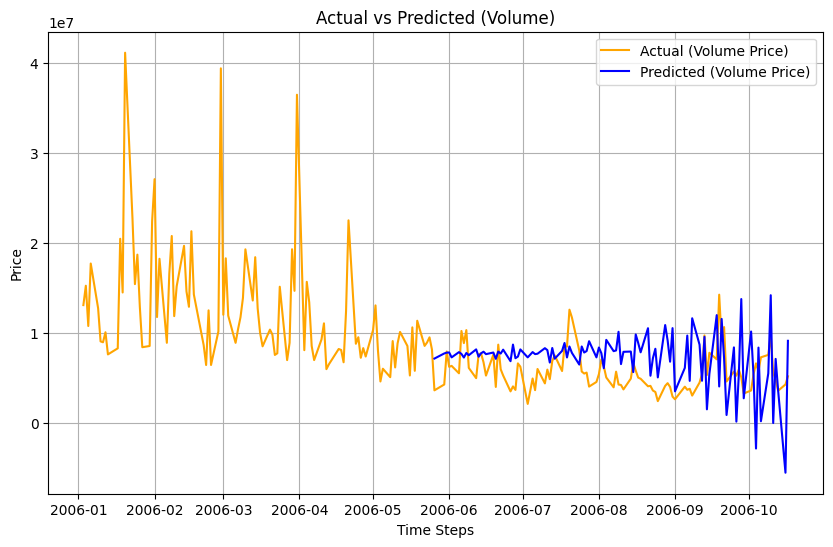

In [22]:
# Plot Actual vs Predicted (First Feature)
for i in range(0,5):
    variable=variables[i]
    plt.figure(figsize=(10, 6))
    plt.plot(df1.index[:200], df1.values[:200, i], label='Actual ('+variable+' Price)', color='orange')  # Actual first feature
    plt.plot(df1.index[100:200], forecasts_rescaled[:, i], label='Predicted ('+variable+' Price)', color='blue')  # Predicted first feature
    plt.legend()
    plt.title("Actual vs Predicted ("+variable+")")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig("Actual_vs_Predicted("+variable+")_testing.png")
    mse = root_mean_squared_error(Y_test_rescaled[:100,i], forecasts_rescaled[:100,i])
    print(f"Root Mean Squared Error: {mse}")


In [18]:
print(df1.values[:200, 3])

[217.83 222.84 225.85 233.06 233.68 235.11 236.05 232.05 233.36 233.79
 222.68 218.44 199.93 213.96 221.74 216.72 217.35 216.96 213.62 216.55
 201.09 198.22 190.97 192.74 184.14 184.72 179.56 181.49 173.02 171.83
 171.36 183.41 184.56 183.48 182.93 189.22 188.89 195.38 181.49 182.58
 188.41 189.28 184.23 182.41 177.12 171.67 168.92 168.7  175.76 172.42
 169.55 170.06 174.27 170.13 170.28 171.12 183.08 185.03 188.79 197.69
 194.41 195.19 195.04 202.37 204.2  205.8  203.28 208.4  205.03 204.68
 201.28 203.61 202.32 205.46 207.71 218.77 220.47 213.79 213.2  210.23
 209.18 199.65 197.6  197.28 197.57 197.35 197.59 204.6  201.69 193.69
 187.25 188.29 185.84 187.44 185.68 185.2  185.66 187.98 190.82 191.69
 190.87 186.16 186.1  191.5  189.91 187.41 195.19 193.45 196.85 193.48
 190.96 193.46 192.39 195.7  195.55 194.26 193.78 201.27 200.17 202.63
 202.31 201.36 203.26 209.11 209.87 211.81 210.94 211.81 210.44 209.31
 212.49 208.83 204.62 201.95 204.15 201.73 199.7  193.75 195.25 195.65
 194.8

In [ ]:
mse = mean_squared_error(Y_test_rescaled[484:], forecasts_rescaled)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6560951163974.439
